# データ分析しやすいようにさらにデータを加工する
0201_Preprocessing.ipynbを読み込んで加工

## ライブラリのインポート

In [1635]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "IPAexGothic" # 日本語の文字化け防止
import seaborn as sns
sns.set(font="IPAexGothic",style="darkgrid")
pd.set_option("display.max_columns", 50) #jupyter notebook上で表示できるカラム数を50に設定

## データの読み込み
- Preprocessing.ipynbを実行して出力されるファイル（train_all.csv/test_all.csv）を利用する

In [1636]:
train = pd.read_csv("data/create/train_all.csv")
test = pd.read_csv("data/create/test_all.csv")

## データを加工＆データを追加する

### 入場者がゼロ(y=0)の時を削除

In [1637]:
train.shape

(1953, 43)

In [1638]:
# train = train[train['y'] != 0]
# train = train[train.y != 0]
train = train[train['y'] != 0]
train.shape

(1952, 43)

### 放送局の数とyを比べてみる

<AxesSubplot:xlabel='tv_num', ylabel='y'>

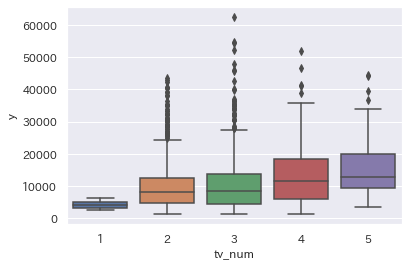

In [1639]:
# "／"で分割した時の長さ=tv数となる
train["tv_num"] = train["tv"].apply(lambda x : len(x.split("／")))
sns.boxplot(x="tv_num", y="y", data=train)

In [1640]:
train.columns

Index(['id', 'y', 'year', 'stage', 'match', 'gameday', 'time', 'home', 'away',
       'stadium', 'tv', 'home_score', 'away_score', 'weather', 'temperature',
       'humidity', 'referee', 'home_team', 'home_01', 'home_02', 'home_03',
       'home_04', 'home_05', 'home_06', 'home_07', 'home_08', 'home_09',
       'home_10', 'home_11', 'away_team', 'away_01', 'away_02', 'away_03',
       'away_04', 'away_05', 'away_06', 'away_07', 'away_08', 'away_09',
       'away_10', 'away_11', 'address', 'capa', 'tv_num'],
      dtype='object')

In [1641]:
test["tv_num"] = test["tv"].apply(lambda x : len(x.split("／")))

### チーム間の距離を出す  
ホームチームとアウェイチームのホームスタジアムの緯度と軽度を取得し、距離を計算する  
home_lat, home_long, away_lat, away_long, distance(km)

In [1642]:
# データの読み込み lat_lng.ipynbで緯度経度取得しteam_home_stadium.csvを作成している
team_home_stadium = pd.read_csv("data/create/team_home_stadium.csv")
# 列の抽出例
team_home_stadium = team_home_stadium.loc[:,['team', 'lat', 'long']]
team_home_stadium.head()
# stageの追加(J1orJ2)
# train['stage', 'home_team']で重複の削除
j1j2_lists = train.loc[:,['stage', 'home_team']].drop_duplicates()
j1j2_lists = j1j2_lists.reindex(columns=['home_team', 'stage']) # 列の入れ替え
j1j2_lists = j1j2_lists.rename(columns={'home_team':'team'}) 
j1j2_lists = pd.merge(team_home_stadium, j1j2_lists, on="team")
j1j2_lists.head(6)

,team,lat,long,stage
0,アビスパ福岡,33.586139,130.460089,Ｊ２
1,アルビレックス新潟,37.882408,139.059359,Ｊ１
2,カターレ富山,36.624048,137.197171,Ｊ２
3,カマタマーレ讃岐,34.261684,133.786361,Ｊ２
4,ガイナーレ鳥取,35.458273,134.221166,Ｊ２
5,ガンバ大阪,34.811971,135.541163,Ｊ１


##### グラフに表示した時に見やすいように緯度の順番ででチームの名前をリストを作る

In [1643]:
# 'stage'順の'lat'順に並び替え
j1j2_lists = j1j2_lists.sort_values(['stage', 'lat'])
# J1とJ2に分ける
j1_lists = j1j2_lists[j1j2_lists['stage'] == 'Ｊ１']
j2_lists = j1j2_lists[j1j2_lists['stage'] == 'Ｊ２']
j1_lists.head(2)

,team,lat,long,stage
29,大分トリニータ,33.200786,131.657500,Ｊ１
10,サガン鳥栖,33.372508,130.520424,Ｊ１


In [1644]:
# 名前だけのリストにする
j1_team_list = j1_lists['team'].tolist()
j2_team_list = j2_lists['team'].tolist()
j1_team_list[0:3]

['大分トリニータ', 'サガン鳥栖', '徳島ヴォルティス']

#### trainとtestに、ホームチーム、アウェイチームに対する緯度経度の列を追加する

In [1645]:
def get_team_lat(team_name):
    """
    team_nameにチーム名指定するとチームのホームスタジアムの緯度を返す。

    >>> get_latlong('横浜ＦＣ')
    35.471264
    """
    lat = team_home_stadium.loc[team_home_stadium['team'] == team_name, 'lat']
    return float(lat)


def get_team_long(team_name):
    long = team_home_stadium.loc[team_home_stadium['team'] == team_name, 'long']
    return float(long)

# print(get_team_lat('ガイナーレ鳥取'))
# print(get_team_lat(team_home_stadium.at[2, 'team']))

In [1646]:
# trainに緯度経度を追加
train['home_lat']  = train['home'].apply(get_team_lat)
train['home_long']  = train['home'].apply(get_team_long)
train['away_lat']  = train['away'].apply(get_team_lat)
train['away_long']  = train['away'].apply(get_team_long)
train.columns
# testに緯度経度を追加
test['home_lat']  = test['home'].apply(get_team_lat)
test['home_long']  = test['home'].apply(get_team_long)
test['away_lat']  = test['away'].apply(get_team_lat)
test['away_long']  = test['away'].apply(get_team_long)
test.columns

Index(['id', 'year', 'stage', 'match', 'gameday', 'time', 'home', 'away',
       'stadium', 'tv', 'home_score', 'away_score', 'weather', 'temperature',
       'humidity', 'referee', 'home_team', 'home_01', 'home_02', 'home_03',
       'home_04', 'home_05', 'home_06', 'home_07', 'home_08', 'home_09',
       'home_10', 'home_11', 'away_team', 'away_01', 'away_02', 'away_03',
       'away_04', 'away_05', 'away_06', 'away_07', 'away_08', 'away_09',
       'away_10', 'away_11', 'address', 'capa', 'tv_num', 'home_lat',
       'home_long', 'away_lat', 'away_long'],
      dtype='object')

#### 2点間の距離を計算し、train['distance(km)']を追加する  
(pip install geopy)

In [1647]:
from geopy.distance import geodesic


def get_km(row):
    """
    homeTeam, awayTeamに緯度経度を指定すると2点間の距離を返す。

    >>> (35.681382, 139.76608399999998), (35.170915, 136.881537)
    267.9938255019848
    """
    homeTeam = row['home_lat'], row['home_long']
    awayTeam = row['away_lat'], row['away_long']
    
    
    dis = geodesic(homeTeam, awayTeam).km
    return dis

# print(get_km((35.681382, 139.76608399999998), (35.170915, 136.881537)))
# 267.9938255019848

In [1648]:
train['distance_km'] = train.apply(get_km, axis=1)
train.columns

test['distance_km'] = test.apply(get_km, axis=1)
test.head(1)

,id,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,home_08,home_09,home_10,home_11,away_team,away_01,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km
0,15822,2014,Ｊ１,第１８節第１日,08/02(土),19:04,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス,2,2,晴,27.4,70%,中村 太,ベガルタ仙台,関 憲太郎,菅井 直樹,渡辺 広大,鎌田 次郎,石川 直樹,太田 吉彰,富田 晋伍,角田 誠,梁 勇基,赤嶺 真吾,ウイルソン,大宮アルディージャ,清水 慶記,中村 北斗,今井 智基,横山 知伸,高橋 祥平,橋本 晃司,和田 拓也,家長 昭博,富山 貴光,ムルジャ,ズラタン,宮城県仙台市泉区七北田字柳78,19694,2,38.319158,140.881857,35.918913,139.63182,288.608038


### スタジアムと観客数で入場率を出し、平均の値をスタジアムの平均入場率と設定する
stage_j1_mobilization, stage_j2_mobilization

In [1649]:
def get_mobilization(row):
    # 観客数/収容人数を計算する
    mobilization = row['y'] / row['capa']
    return mobilization

# print(get_km((35.681382, 139.76608399999998), (35.170915, 136.881537)))
# 267.9938255019848

In [1650]:
# 観客y/スタジアムcapa で'mobilization'列（観客動員率）を作る
train['mobilization'] = train.apply(get_mobilization, axis=1)

In [1651]:
# スタジアムごとの入場率の中央値を、設定する
stage_j1 = train[train["stage"]=="Ｊ１"]
stage_j1_mobilization = stage_j1.groupby(["stadium"]).median()['mobilization'].reset_index()
stage_j2 = train[train["stage"]=="Ｊ２"]
stage_j2_mobilization = stage_j2.groupby(["stadium"]).median()['mobilization'].reset_index()
stage_j2_mobilization

,stadium,mobilization
0,うまかな・よかなスタジアム,0.187766
1,とりぎんバードスタジアム,0.206480
2,ケーズデンキスタジアム水戸,0.351458
3,シティライトスタジアム,0.393850
4,ニッパツ三ツ沢球技場,0.362398
5,ニンジニアスタジアム,0.226759
6,ノエビアスタジアム神戸,0.337183
7,フクダ電子アリーナ,0.503730
8,ヤマハスタジアム（磐田）,0.528586
9,レベルファイブスタジアム,0.227142


In [1652]:
train.columns

Index(['id', 'y', 'year', 'stage', 'match', 'gameday', 'time', 'home', 'away',
       'stadium', 'tv', 'home_score', 'away_score', 'weather', 'temperature',
       'humidity', 'referee', 'home_team', 'home_01', 'home_02', 'home_03',
       'home_04', 'home_05', 'home_06', 'home_07', 'home_08', 'home_09',
       'home_10', 'home_11', 'away_team', 'away_01', 'away_02', 'away_03',
       'away_04', 'away_05', 'away_06', 'away_07', 'away_08', 'away_09',
       'away_10', 'away_11', 'address', 'capa', 'tv_num', 'home_lat',
       'home_long', 'away_lat', 'away_long', 'distance_km', 'mobilization'],
      dtype='object')

In [1653]:
# 'stage'と'stadium'を合わせた列を作る 参照用に作るので今後は不要
# Ｊ１ユアテックスタジアム仙台= Ｊ１ + ユアテックスタジアム仙台
train['stage_stadium'] = train.apply(lambda x: f"{x['stage']}{x['stadium']}", axis=1)
test['stage_stadium'] = test.apply(lambda x: f"{x['stage']}{x['stadium']}", axis=1)

In [1654]:

def get_stadium_mobilization(stage_stadium):
    if stage_stadium[:2] == 'Ｊ１':
        set_df = stage_j1_mobilization
    else:
        set_df = stage_j2_mobilization
    ans = set_df.loc[set_df['stadium'] == stage_stadium[2:], 'mobilization']
    return float(ans)

In [1655]:
# train['stadium_mobilization'] = test['stage_stadium'].apply(get_stadium_mobilization, axis=1)
train['stadium_mobilization'] = train['stage_stadium'].apply(get_stadium_mobilization)
test['stadium_mobilization'] = test['stage_stadium'].apply(get_stadium_mobilization)
train.head(1)


,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,...,home_10,home_11,away_team,away_01,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km,mobilization,stage_stadium,stadium_mobilization
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,鎌田 次郎,上本 大海,田村 直也,富田 晋伍,角田 誠,...,ウイルソン,赤嶺 真吾,鹿島アントラーズ,曽ヶ端 準,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,4,38.319158,140.881857,35.992776,140.641766,259.062331,0.926678,Ｊ１ユアテックスタジアム仙台,0.766782


In [1656]:
train[train["stage"]=="Ｊ２"].head(1)
# OK!

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,...,home_10,home_11,away_team,away_01,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km,mobilization,stage_stadium,stadium_mobilization
306,14300,5817,2012,Ｊ２,第１節第１日,03/04(日),13:05,水戸ホーリーホック,横浜ＦＣ,ケーズデンキスタジアム水戸,スカパー／ｅ２（スカイ・Ａ ｓｐｏｒｔｓ＋）／スカパー光,2,1,曇,7.4,53%,河合 英治,水戸ホーリーホック,本間 幸司,市川 大祐,金 龍起,塩谷 司,輪湖 直樹,西岡 謙太,ロメロ フランク,...,橋本 晃司,鈴木 隆行,横浜ＦＣ,関 憲太郎,杉山 新,渡邉 将基,ペ スンジン,阿部 巧,ホベルト,中里 崇宏,内田 智也,野崎 陽介,難波 宏明,大久保 哲哉,茨城県水戸市小吹町2058-1,12000,3,36.345446,140.411495,35.471264,139.60246,121.414424,0.48475,Ｊ２ケーズデンキスタジアム水戸,0.351458


### 月と曜日を分けて列を作る

In [1657]:
# 月はgamedayの先頭2文字で表現されている為、先頭2文字を取り出し、整数に直す
train["MONTH"] = train["gameday"].apply(lambda x : x[0:2])
train["MONTH"] = train["MONTH"].astype(np.int)

# 曜日はgamedayのカッコで表記されている為、カッコを手掛かりに抜き出す
# find関数は文字列の時に利用できる関数で、オプションで指定した文字の位置を返す
train["WEEK"] = train["gameday"].apply(lambda x : x[x.find("(")+1:x.find("(")+2]) 
train.head(1)

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,...,away_team,away_01,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km,mobilization,stage_stadium,stadium_mobilization,MONTH,WEEK
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,鎌田 次郎,上本 大海,田村 直也,富田 晋伍,角田 誠,...,鹿島アントラーズ,曽ヶ端 準,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,4,38.319158,140.881857,35.992776,140.641766,259.062331,0.926678,Ｊ１ユアテックスタジアム仙台,0.766782,3,土


In [1658]:
# testに対しても同様に処理
test["MONTH"] = test["gameday"].apply(lambda x : x[0:2])
test["MONTH"] = test["MONTH"].astype(np.int)

test["WEEK"] = test["gameday"].apply(lambda x : x[x.find("(")+1:x.find("(")+2]) 
test.head(1)

,id,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,home_08,...,home_11,away_team,away_01,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km,stage_stadium,stadium_mobilization,MONTH,WEEK
0,15822,2014,Ｊ１,第１８節第１日,08/02(土),19:04,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス,2,2,晴,27.4,70%,中村 太,ベガルタ仙台,関 憲太郎,菅井 直樹,渡辺 広大,鎌田 次郎,石川 直樹,太田 吉彰,富田 晋伍,角田 誠,...,ウイルソン,大宮アルディージャ,清水 慶記,中村 北斗,今井 智基,横山 知伸,高橋 祥平,橋本 晃司,和田 拓也,家長 昭博,富山 貴光,ムルジャ,ズラタン,宮城県仙台市泉区七北田字柳78,19694,2,38.319158,140.881857,35.918913,139.63182,288.608038,Ｊ１ユアテックスタジアム仙台,0.766782,8,土


### 時間(time)を昼か夜にする

In [1659]:
# 18時まではお昼開催:0, 18時以降は夜開催:1
train["timezone"] = train["time"].apply(lambda x : 0 if int(x[0:2])>= 18 else 1)
test["timezone"] = test["time"].apply(lambda x : 0 if int(x[0:2])>= 18 else 1)
train.head()

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,...,away_01,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km,mobilization,stage_stadium,stadium_mobilization,MONTH,WEEK,timezone
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,鎌田 次郎,上本 大海,田村 直也,富田 晋伍,角田 誠,...,曽ヶ端 準,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,4,38.319158,140.881857,35.992776,140.641766,259.062331,0.926678,Ｊ１ユアテックスタジアム仙台,0.766782,3,土,1
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋,1,0,屋内,12.4,43%,西村 雄一,名古屋グランパス,楢﨑 正剛,田中 隼磨,田中 マルクス闘莉王,増川 隆洋,阿部 翔平,中村 直志,ダニルソン,...,林 彰洋,吉田 豊,岩下 敬輔,カルフィン ヨン ア ピン,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀,愛知県豊田市千石町7-2,40000,4,35.088621,137.171555,34.985168,138.481305,120.059935,0.607900,Ｊ１豊田スタジアム,0.512800,3,土,1
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪,2,3,晴一時雨,11.3,41%,高山 啓義,ガンバ大阪,藤ヶ谷 陽介,加地 亮,中澤 聡太,今野 泰幸,藤春 廣輝,明神 智和,遠藤 保仁,...,徳重 健太,近藤 岳登,北本 久仁衛,伊野波 雅彦,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人,大阪府吹田市千里万博公園5-2,21000,4,34.811971,135.541163,34.656726,135.168171,38.255309,0.812667,Ｊ１万博記念競技場,0.712667,3,土,1
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島,1,0,曇一時雨のち晴,11.4,52%,松尾 一,サンフレッチェ広島,西川 周作,森脇 良太,千葉 和彦,水本 裕貴,ミキッチ,青山 敏弘,森﨑 和幸,...,加藤 順大,濱田 水輝,阿部 勇樹,槙野 智章,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也,広島県広島市安佐南区大塚西5-1-1,50000,4,34.441236,132.395422,35.902000,139.714677,685.986038,0.592060,Ｊ１エディオンスタジアム広島,0.306080,3,土,1
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌,0,0,屋内,22.5,32%,廣瀬 格,コンサドーレ札幌,李 昊乗,高木 純平,ジェイド ノース,奈良 竜樹,岩沼 俊介,河合 竜二,山本 真希,...,川口 能活,駒野 友一,チョ ビョングク,藤田 義明,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,北海道札幌市豊平区羊ヶ丘1,39232,4,42.990187,141.392009,34.722804,137.878302,966.885906,0.646233,Ｊ１札幌ドーム,0.330954,3,土,1


### 曜日と時間帯を合わせる
日曜日の夜の試合はawayには応援に行かないのではないか

In [1660]:
train['WEEK_timezone_num'] = train.apply(lambda x: f"{x['WEEK']}{x['timezone']}", axis=1)
test['WEEK_timezone_num'] = test.apply(lambda x: f"{x['WEEK']}{x['timezone']}", axis=1)

### TVでNHK総合で放送しているか
予測後の残差検証でNHK総合が絡んでいるのが大きく外れていたので、グラフ化  
スタジアムごとの観客数で見た時に、NHK総合が放送されている試合は観客数が多かった  

In [1661]:
# tvに'NHK総合'が含まれていたら:1、含まない時は:0
train["nhk"] = train["tv"].apply(lambda x : 1 if 'ＮＨＫ総合' in x else 0)
test["nhk"] = test["tv"].apply(lambda x : 1 if 'ＮＨＫ総合' in x else 0)
train.head()

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,...,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km,mobilization,stage_stadium,stadium_mobilization,MONTH,WEEK,timezone,WEEK_timezone_num,nhk
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,鎌田 次郎,上本 大海,田村 直也,富田 晋伍,角田 誠,...,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,4,38.319158,140.881857,35.992776,140.641766,259.062331,0.926678,Ｊ１ユアテックスタジアム仙台,0.766782,3,土,1,土1,1
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋,1,0,屋内,12.4,43%,西村 雄一,名古屋グランパス,楢﨑 正剛,田中 隼磨,田中 マルクス闘莉王,増川 隆洋,阿部 翔平,中村 直志,ダニルソン,...,岩下 敬輔,カルフィン ヨン ア ピン,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀,愛知県豊田市千石町7-2,40000,4,35.088621,137.171555,34.985168,138.481305,120.059935,0.607900,Ｊ１豊田スタジアム,0.512800,3,土,1,土1,0
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪,2,3,晴一時雨,11.3,41%,高山 啓義,ガンバ大阪,藤ヶ谷 陽介,加地 亮,中澤 聡太,今野 泰幸,藤春 廣輝,明神 智和,遠藤 保仁,...,北本 久仁衛,伊野波 雅彦,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人,大阪府吹田市千里万博公園5-2,21000,4,34.811971,135.541163,34.656726,135.168171,38.255309,0.812667,Ｊ１万博記念競技場,0.712667,3,土,1,土1,0
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島,1,0,曇一時雨のち晴,11.4,52%,松尾 一,サンフレッチェ広島,西川 周作,森脇 良太,千葉 和彦,水本 裕貴,ミキッチ,青山 敏弘,森﨑 和幸,...,阿部 勇樹,槙野 智章,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也,広島県広島市安佐南区大塚西5-1-1,50000,4,34.441236,132.395422,35.902000,139.714677,685.986038,0.592060,Ｊ１エディオンスタジアム広島,0.306080,3,土,1,土1,0
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌,0,0,屋内,22.5,32%,廣瀬 格,コンサドーレ札幌,李 昊乗,高木 純平,ジェイド ノース,奈良 竜樹,岩沼 俊介,河合 竜二,山本 真希,...,チョ ビョングク,藤田 義明,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,北海道札幌市豊平区羊ヶ丘1,39232,4,42.990187,141.392009,34.722804,137.878302,966.885906,0.646233,Ｊ１札幌ドーム,0.330954,3,土,1,土1,0


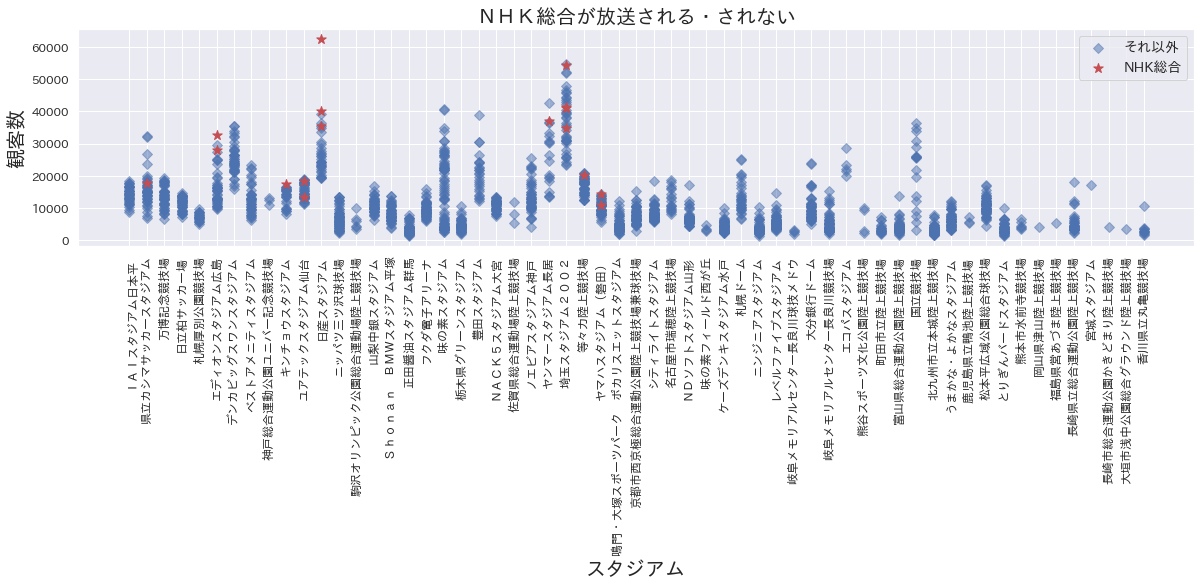

In [1725]:
# plt.xlim(15.0, 40.0) # x軸の表示範囲
# plt.ylim(300, 750) # y軸の表示範囲
plt.figure(figsize=(20,4))
plt.title('ＮＨＫ総合が放送される・されない', fontsize=20) # タイトル
plt.xlabel("スタジアム", fontsize=20) # x軸ラベル
plt.ylabel("観客数", fontsize=20) # y軸ラベル
plt.grid(True) # 目盛線の表示
plt.tick_params(labelsize = 12) # 目盛線のラベルサイズ

# グラフの描画 マークの設定(s:サイズ, c:色, marker:形, alpha:透過)
plt.scatter(x="stadium",y="y",data=train[(train["nhk"]==0)], s=50, c="b", marker="D", alpha=0.5, label="それ以外")
plt.scatter(x="stadium",y="y",data=train[(train["nhk"]==1)], s=100, c="r", marker="*", alpha=1, label="NHK総合")

plt.legend(loc="upper right", fontsize=14) # 凡例表示
plt.xticks(rotation=90)
plt.show()

/var/folders/x4/8hbz4flj6_bg96s9y3b69rb80000gn/T/ipykernel_811/3727830364.py:12: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(x="stadium",y="mobilization",data=train[(train["stage"]=='Ｊ１')&train['year']==2014], s=100, c="r", marker="*", alpha=1, label="NHK総合")


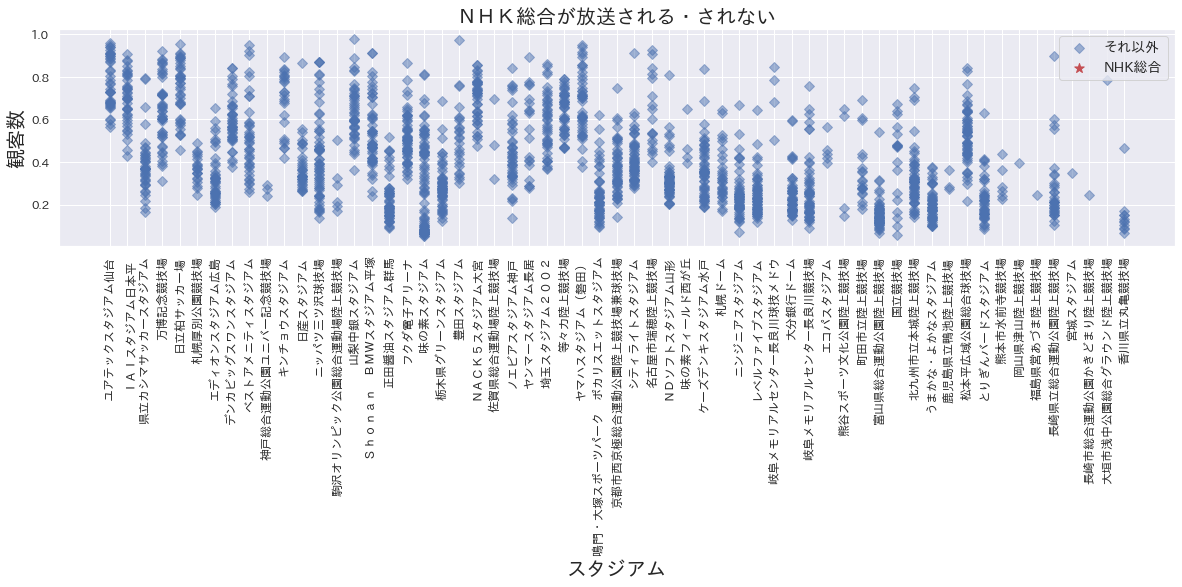

In [1730]:
# plt.xlim(15.0, 40.0) # x軸の表示範囲
# plt.ylim(300, 750) # y軸の表示範囲
plt.figure(figsize=(20,4))
plt.title('ＮＨＫ総合が放送される・されない', fontsize=20) # タイトル
plt.xlabel("スタジアム", fontsize=20) # x軸ラベル
plt.ylabel("観客数", fontsize=20) # y軸ラベル
plt.grid(True) # 目盛線の表示
plt.tick_params(labelsize = 12) # 目盛線のラベルサイズ

# グラフの描画 マークの設定(s:サイズ, c:色, marker:形, alpha:透過)
plt.scatter(x="stadium",y="mobilization",data=train[(train["stage"]=='Ｊ１')&train['year']<2014], s=50, c="b", marker="D", alpha=0.5, label="それ以外")
plt.scatter(x="stadium",y="mobilization",data=train[(train["stage"]=='Ｊ１')&train['year']==2014], s=100, c="r", marker="*", alpha=1, label="NHK総合")

plt.legend(loc="upper right", fontsize=14) # 凡例表示
plt.xticks(rotation=90)
plt.show()

In [1728]:
train[(train['stadium']=='ベストアメニティスタジアム')&(train['mobilization']>=0.7)]

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,...,away_lat,away_long,distance_km,mobilization,stage_stadium,stadium_mobilization,MONTH,WEEK,timezone,WEEK_timezone_num,nhk,WEATHER,temp_condition,hours,over_mobilization,holiday,referee_point,stadium_min,stadium_max,referee_j1games,referee_j2games,referee_irl,referee_career,referee_lastj1games,referee_lastj2games
10,14209,19729,2012,Ｊ１,第２４節第１日,09/01(土),19:04,サガン鳥栖,ガンバ大阪,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光,4,1,晴,25.4,63%,木村 博之,サガン鳥栖,赤星 拓,丹羽 竜平,キム クナン,呂 成海,磯崎 敬太,岡本 知剛,藤田 直之,...,34.811971,135.541163,490.007038,0.805594,Ｊ１ベストアメニティスタジアム,0.494692,9,土,0,土0,0,晴,1.0,19,1.628477,0,1,6292,23277,26,55,0,4,15,11
308,14290,22116,2012,Ｊ１,第３３節第１日,11/24(土),14:35,サガン鳥栖,浦和レッズ,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス／ＮＨＫ佐賀,3,1,曇,13.1,47%,吉田 寿光,サガン鳥栖,赤星 拓,丹羽 竜平,小林 久晃,キム クナン,金 民友,水沼 宏太,高橋 義希,...,35.902000,139.714677,888.052830,0.903062,Ｊ１ベストアメニティスタジアム,0.494692,11,土,1,土1,0,曇,1.0,14,1.825506,0,1,6292,23277,256,95,0,17,25,10
438,14070,18113,2012,Ｊ１,第９節第１日,05/03(木・祝),16:04,サガン鳥栖,ベガルタ仙台,ベストアメニティスタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）,1,1,曇,20.0,60%,福島 孝一郎,サガン鳥栖,赤星 拓,丹羽 竜平,小林 久晃,キム クナン,呂 成海,岡本 知剛,藤田 直之,...,38.319158,140.881857,1084.067142,0.739608,Ｊ１ベストアメニティスタジアム,0.494692,5,木,1,木1,0,曇,1.0,16,1.495089,1,1,6292,23277,0,18,0,1,0,18
815,15105,17382,2013,Ｊ１,第３０節第２日,10/27(日),19:04,サガン鳥栖,セレッソ大阪,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１,2,0,晴,17.1,48%,飯田 淳平,サガン鳥栖,林 彰洋,丹羽 竜平,菊地 直哉,坂井 達弥,磯崎 敬太,早坂 良太,高橋 義希,...,34.615219,135.525871,482.502134,0.709759,Ｊ１ベストアメニティスタジアム,0.494692,10,日,0,日0,0,晴,1.0,19,1.434750,0,1,6292,23277,61,59,1,6,18,7
957,15021,22530,2013,Ｊ１,第２１節第１日,08/17(土),19:03,サガン鳥栖,大宮アルディージャ,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１,2,1,晴,31.1,56%,高山 啓義,サガン鳥栖,林 彰洋,丹羽 竜平,呂 成海,菊地 直哉,金 民友,水沼 宏太,藤田 直之,...,35.918913,139.631820,881.374160,0.919967,Ｊ１ベストアメニティスタジアム,0.494692,8,土,0,土0,0,晴,-1.1,19,1.859678,0,0,6292,23277,141,43,1,13,16,9
959,15131,20196,2013,Ｊ１,第３３節第１日,11/30(土),14:03,サガン鳥栖,浦和レッズ,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／ＮＨＫ佐賀,4,1,晴,12.9,41%,高山 啓義,サガン鳥栖,林 彰洋,丹羽 竜平,菊地 直哉,坂井 達弥,磯崎 敬太,早坂 良太,高橋 義希,...,35.902000,139.714677,888.052830,0.824663,Ｊ１ベストアメニティスタジアム,0.494692,11,土,1,土1,0,晴,1.0,14,1.667024,0,0,6292,23277,141,43,1,13,16,9
1639,15812,23277,2014,Ｊ１,第１６節第１日,07/23(水),19:04,サガン鳥栖,川崎フロンターレ,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス,0,1,曇,29.2,77%,松尾 一,サガン鳥栖,林 彰洋,丹羽 竜平,菊地 直哉,キム ミンヒョク,安田 理大,早坂 良太,岡本 知剛,...,35.590090,139.647336,873.352780,0.950470,Ｊ１ベストアメニティスタジアム,0.494692,7,水,0,水0,0,曇,1.0,19,1.921337,0,1,6292,23277,176,68,0,15,19,11
1681,15753,17339,2014,Ｊ１,第１０節第１日,04/29(火・祝),14:00,サガン鳥栖,サンフレッチェ広島,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス／ＮＨＫ佐賀,1,2,曇,18.0,68%,岡部 拓人,サガン鳥栖,林 彰洋,丹羽 竜平,キム ミンヒョク,坂井 達弥,安田 理大,水沼 宏太,高橋 義希,...,34.441236,132.395422,210.049681,0.708003,Ｊ１ベストアメニティスタジアム,0.494692,4,火,1,火1,0,曇,1.0,14,1.431201,1,1,6292,23277,27,97,0,6,11,9


### 天気列を追加する 天気の一文字目で列を作成

In [1662]:
train["WEATHER"] = train["weather"].apply(lambda x : x[0])
test["WEATHER"] = test["weather"].apply(lambda x : x[0])

<AxesSubplot:xlabel='WEATHER', ylabel='y'>

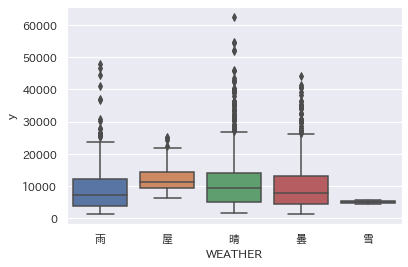

In [1663]:
tmp = train[["y", "WEATHER"]].copy()
sns.boxplot(x="WEATHER", y="y", data=tmp)

### 気温による観客数の変化を重みをつける
気温が4度以下、31度以上は観客が少ない  
でも  
temp_conditionより、temperatureの方が予測値がいい

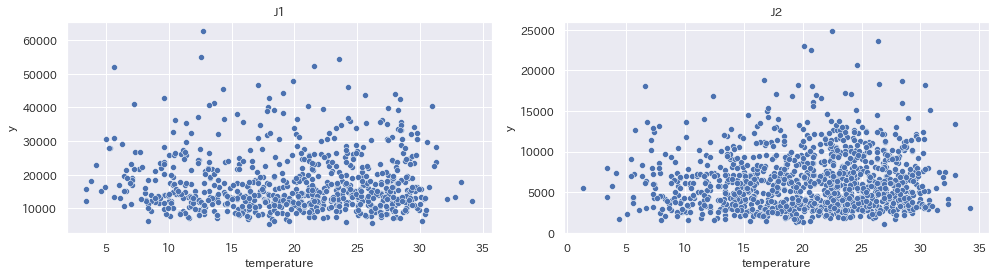

In [1664]:
# 複数の絵を同時に描きたい時にsubplots関数を使う
fig,ax = plt.subplots(1,2,figsize=(14,4))

ax[0].set_title("J1")
sns.scatterplot(x="temperature",y="y",data=train[train["stage"]=="Ｊ１"], ax=ax[0])
ax[1].set_title("J2")
sns.scatterplot(x="temperature",y="y",data=train[train["stage"]=="Ｊ２"], ax=ax[1])
plt.tight_layout()

In [1665]:
# 31度=1, 3.2度=1.8 みたいに重みをつける
train["temp_condition"] = train["temperature"].apply(lambda x: 30-x if x > 30 else(x-5 if x < 5 else 1))
test["temp_condition"] = test["temperature"].apply(lambda x: 30-x if x > 30 else(x-5 if x < 5 else 1))

### 試合開始時間
含めると予測数値が下がった

In [1666]:
train["hours"] = train["time"].apply(lambda x: x[:2])
test["hours"] = test["time"].apply(lambda x: x[:2])

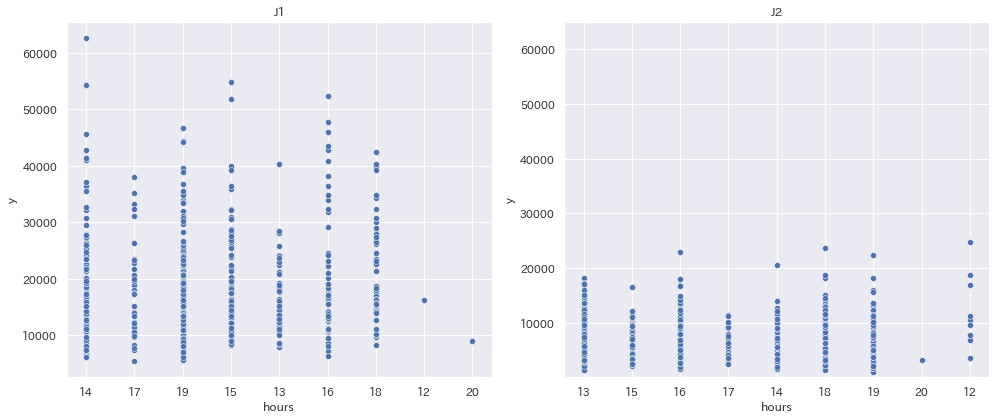

In [1667]:
# 複数の絵を同時に描きたい時にsubplots関数を使う
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].set_title("J1")
sns.scatterplot(x="hours",y="y",data=train[train["stage"]=="Ｊ１"], ax=ax[0])
ax[1].set_title("J2")
sns.scatterplot(x="hours",y="y",data=train[train["stage"]=="Ｊ２"], ax=ax[1])
plt.ylim(100,65000)
plt.tight_layout()
# 20時始まりは少なそう

In [1668]:
train['over_mobilization'] = train.apply(lambda x: x['mobilization']/x['stadium_mobilization'], axis=1)

### 祝日と休日
祝日と祝日以外で比較。祝日はイベントなどもあるから観客が多い

In [1669]:
# 祝日だけのdf
holiday=train[train['gameday'].str.contains('祝')]
# 休日だけのdf
holiday_2=train[train['gameday'].str.contains('休')]

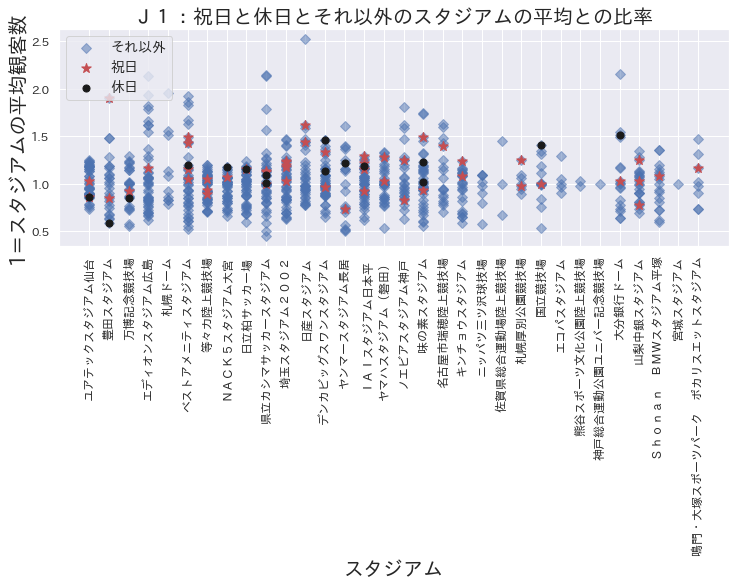

In [1670]:
# plt.xlim(15.0, 40.0) # x軸の表示範囲
# plt.ylim(300, 750) # y軸の表示範囲
plt.figure(figsize=(12,4))
plt.title('Ｊ１：祝日と休日とそれ以外のスタジアムの平均との比率', fontsize=20) # タイトル
plt.xlabel("スタジアム", fontsize=20) # x軸ラベル
plt.ylabel("1＝スタジアムの平均観客数", fontsize=20) # y軸ラベル
plt.grid(True) # 目盛線の表示
plt.tick_params(labelsize = 12) # 目盛線のラベルサイズ

# グラフの描画 マークの設定(s:サイズ, c:色, marker:形, alpha:透過)
plt.scatter(x="stadium",y="over_mobilization",data=train[(train["stage"]=="Ｊ１")], s=50, c="b", marker="D", alpha=0.5, label="それ以外")
plt.scatter(x="stadium",y="over_mobilization",data=holiday[(holiday["stage"]=="Ｊ１")], s=100, c="r", marker="*", alpha=1, label="祝日")
plt.scatter(x="stadium",y="over_mobilization",data=holiday_2[(holiday_2["stage"]=="Ｊ１")], s=50, c="k", marker="o", alpha=1, label="休日")
plt.legend(loc="upper left", fontsize=14) # 凡例表示
plt.xticks(rotation=90)
plt.show()

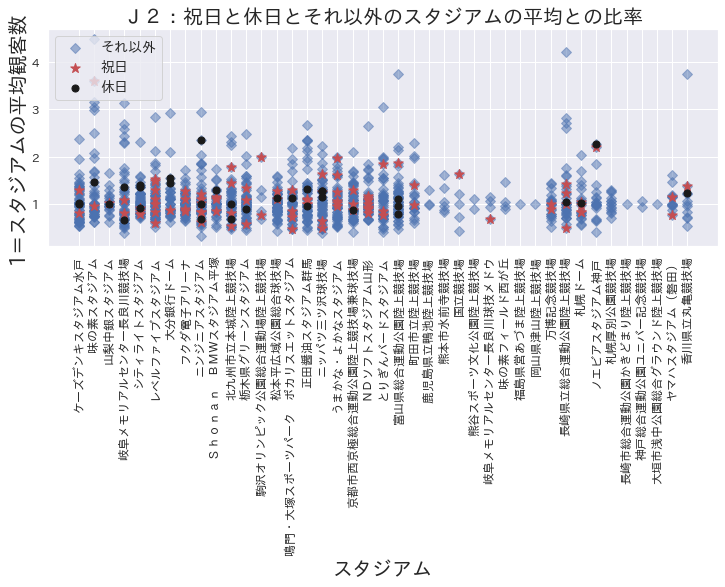

In [1671]:
# plt.xlim(15.0, 40.0) # x軸の表示範囲
# plt.ylim(300, 750) # y軸の表示範囲
plt.figure(figsize=(12,4))
plt.title('Ｊ２：祝日と休日とそれ以外のスタジアムの平均との比率', fontsize=20) # タイトル
plt.xlabel("スタジアム", fontsize=20) # x軸ラベル
plt.ylabel("1＝スタジアムの平均観客数", fontsize=20) # y軸ラベル
plt.grid(True) # 目盛線の表示
plt.tick_params(labelsize = 12) # 目盛線のラベルサイズ

plt.scatter(x="stadium",y="over_mobilization",data=train[(train["stage"]=="Ｊ２")], s=50, c="b", marker="D", alpha=0.5, label="それ以外")
plt.scatter(x="stadium",y="over_mobilization",data=holiday[(holiday["stage"]=="Ｊ２")], s=100, c="r", marker="*", alpha=1, label="祝日")
plt.scatter(x="stadium",y="over_mobilization",data=holiday_2[(holiday_2["stage"]=="Ｊ２")], s=50, c="k", marker="o", alpha=1, label="休日")

plt.legend(loc="upper left", fontsize=14) # 凡例表示
plt.xticks(rotation=90)
plt.show()

In [1672]:
train["holiday"] = train["gameday"].apply(lambda x: 1 if '祝' in x else 0)
test["holiday"] = test["gameday"].apply(lambda x: 1 if '祝' in x else 0)

### 審判でわかるのではないか
大事な試合はこの人が審判する.とか

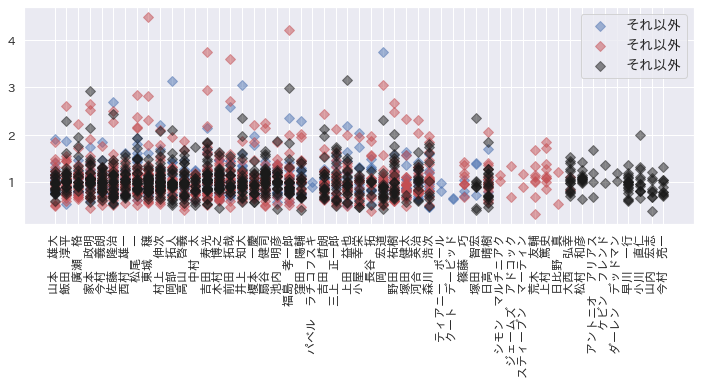

In [1673]:
plt.figure(figsize=(12,4))
plt.grid(True) # 目盛線の表示
plt.tick_params(labelsize = 12) # 目盛線のラベルサイズ

# グラフの描画 マークの設定(s:サイズ, c:色, marker:形, alpha:透過)
plt.scatter(x="referee",y="over_mobilization",data=train[(train["year"]==2014)], s=50, c="b", marker="D", alpha=0.5, label="それ以外")
plt.scatter(x="referee",y="over_mobilization",data=train[(train["year"]==2013)], s=50, c="r", marker="D", alpha=0.5, label="それ以外")
plt.scatter(x="referee",y="over_mobilization",data=train[(train["year"]==2012)], s=50, c="k", marker="D", alpha=0.5, label="それ以外")

plt.legend(loc="upper right", fontsize=14) # 凡例表示
plt.xticks(rotation=90)
plt.show()

審判ごとにover_mobilization(スタジアムの平均と比べてどうか)の平均を出し、それを審判のポイントとする

In [1674]:
referee_df=train.loc[:,['referee','over_mobilization']]
referee_df=referee_df.groupby('referee', as_index=False).mean()
referee_df.head()


,referee,over_mobilization
0,アントニオ アリアス,1.130939
1,クート デービッド,0.653421
2,ケビン フレンド,1.168181
3,シモン マルチニアク,1.082975
4,ジェームズ アドコック,1.006859


In [1675]:
over_mobilization_df=train[(train['over_mobilization']>1.5)&(train['MONTH']>=9)]
over_mobilization_df=over_mobilization_df.loc[:,['referee','home','away','year','gameday','over_mobilization','match']]
# over_mobilization_df=over_mobilization_df.groupby('referee', 'home','away','over_mobilization')
over_mobilization_df=over_mobilization_df.sort_values(by="home")[['referee','home','away','year','gameday','match','over_mobilization']]
over_mobilization_df.head(1)

,referee,home,away,year,gameday,match,over_mobilization
1534,長谷 拓,アビスパ福岡,ファジアーノ岡山,2013,11/24(日),第４２節第１日,1.874146


#### over_mobilizationで2.5以上の人に`1`をつけるやり方  
スコアが伸びなかったのでコメントアウト
'year', 'referee', 'referee_j1games', 'referee_j2games', 'referee_irl',
       'referee_career', 'referee_lastj1games', 'referee_lastj2games'

In [1676]:
# over_mobilization_df=train[train['over_mobilization']>2.5]

In [1677]:
# referee_df=train.loc[:,['referee','year','over_mobilization']]]>=1 else 0)

In [1678]:
# referee_df.head()

#### 国際審判の実績で大事な試合はこの審判が担当するってわかるのではいか
referee_add.csv  webより検索したものをまとめている

In [1705]:
referee_license_df = pd.read_csv('data/create/referee_add.csv')
referee_license_df.shape

(122, 8)

In [1704]:
referee_license_df.head(1)

,year,referee,referee_j1games,referee_j2games,referee_irl,referee_career,referee_lastj1games,referee_lastj2games
0,2012,木村 博之,26,55,0,4,15,11


In [1706]:
train.shape

(1952, 65)

In [1708]:
train = pd.merge(train,referee_license_df,on=["year","referee"])
# train = train.sort_values(by="id")
train.shape

(1952, 71)

In [1679]:
train['referee_point'] = train['referee'].apply(lambda x : int(referee_df.loc[referee_df['referee'] == x, 'over_mobilization']))
test['referee_point'] = test['referee'].apply(lambda x : int(referee_df.loc[referee_df['referee'] == x, 'over_mobilization']))
train.head(1)


,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,...,away_09,away_10,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km,mobilization,stage_stadium,stadium_mobilization,MONTH,WEEK,timezone,WEEK_timezone_num,nhk,WEATHER,temp_condition,hours,over_mobilization,holiday,referee_point
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,鎌田 次郎,上本 大海,田村 直也,富田 晋伍,角田 誠,...,本山 雅志,大迫 勇也,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,4,38.319158,140.881857,35.992776,140.641766,259.062331,0.926678,Ｊ１ユアテックスタジアム仙台,0.766782,3,土,1,土1,1,雨,-1.2,14,1.208529,0,1


### スタジアムの観客数min値とmax値
testデータで予測をした後、スタジアムの最小値より小さい値だった時、補正するのに使う

In [1680]:
# スタジアムごとの入場率の最小を、設定する
stage_min_Gby = train.groupby(["stadium"]).min()['y'].reset_index()
stage_min_Gby.head()

,stadium,y
0,うまかな・よかなスタジアム,3127
1,とりぎんバードスタジアム,1363
2,エコパスタジアム,20049
3,エディオンスタジアム広島,9515
4,キンチョウスタジアム,8226


In [1681]:
# スタジアムごとの入場率の最大を、設定する
stage_max_Gby = train.groupby(["stadium"]).max()['y'].reset_index()
stage_max_Gby.head()

,stadium,y
0,うまかな・よかなスタジアム,12003
1,とりぎんバードスタジアム,10096
2,エコパスタジアム,28745
3,エディオンスタジアム広島,32724
4,キンチョウスタジアム,17489


In [1682]:
# train['stadium_mobilization'] = test['stage_stadium'].apply(get_stadium_mobilization, axis=1)
train['stadium_min'] = train["stadium"].apply(lambda x: int(stage_min_Gby.loc[stage_min_Gby['stadium'] == x, 'y']))
test['stadium_min'] = test["stadium"].apply(lambda x: int(stage_min_Gby.loc[stage_min_Gby['stadium'] == x, 'y']))
train['stadium_max'] = train["stadium"].apply(lambda x: int(stage_max_Gby.loc[stage_max_Gby['stadium'] == x, 'y']))
test['stadium_max'] = test["stadium"].apply(lambda x: int(stage_max_Gby.loc[stage_max_Gby['stadium'] == x, 'y']))
train.head(1)

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,...,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km,mobilization,stage_stadium,stadium_mobilization,MONTH,WEEK,timezone,WEEK_timezone_num,nhk,WEATHER,temp_condition,hours,over_mobilization,holiday,referee_point,stadium_min,stadium_max
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,鎌田 次郎,上本 大海,田村 直也,富田 晋伍,角田 誠,...,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,4,38.319158,140.881857,35.992776,140.641766,259.062331,0.926678,Ｊ１ユアテックスタジアム仙台,0.766782,3,土,1,土1,1,雨,-1.2,14,1.208529,0,1,11144,18863


In [1683]:
# 確認用
mm=stage_min_Gby.loc[stage_min_Gby['stadium'] == 'ユアテックスタジアム仙台', 'y']
mm

15    11144
Name: y, dtype: int64

考察中のコード

湿度による変化はどうか

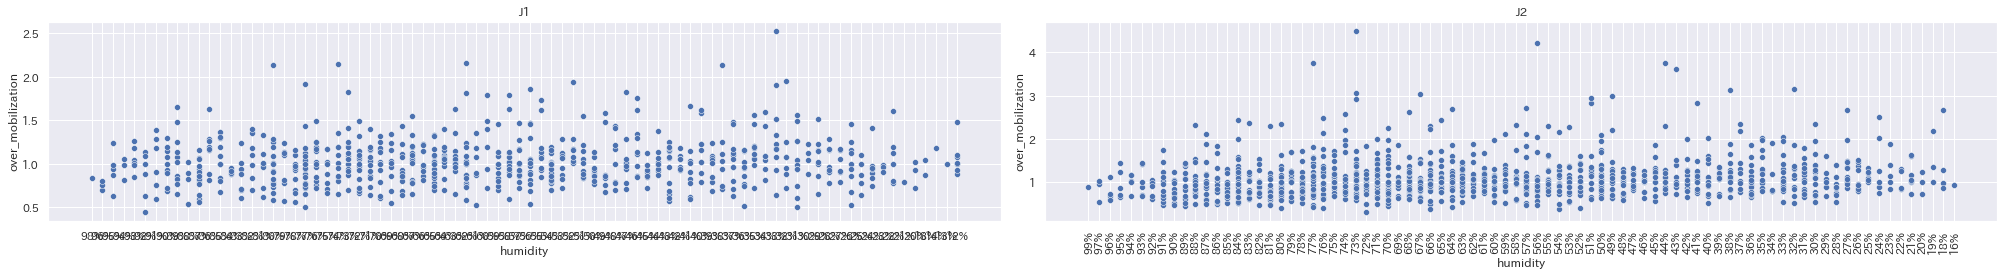

In [1684]:
# 複数の絵を同時に描きたい時にsubplots関数を使う
fig,ax = plt.subplots(1,2,figsize=(28,4))

ax[0].set_title("J1")
sns.scatterplot(x="humidity",y="over_mobilization",data=train[train["stage"]=="Ｊ１"].sort_values(by="humidity",ascending=False), ax=ax[0])
ax[1].set_title("J2")
sns.scatterplot(x="humidity",y="over_mobilization",data=train[train["stage"]=="Ｊ２"].sort_values(by="humidity",ascending=False), ax=ax[1])
plt.xticks(rotation=90)
plt.tight_layout()

# 列を追加したものをcsvに出力する

In [1685]:
train.shape

(1952, 65)

In [1686]:
test.shape

(313, 62)

In [1687]:
train.isnull().sum()

id                   0
y                    0
year                 0
stage                0
match                0
                    ..
over_mobilization    0
holiday              0
referee_point        0
stadium_min          0
stadium_max          0
Length: 65, dtype: int64

In [1688]:
#文字コードをutf8に統一する為に、encoding="utf8"というオプションを記載
train.to_csv("data/create/train_all_column_addition.csv",index=None,encoding="utf8")
test.to_csv("data/create/test_all_column_addition.csv",index=None,encoding="utf8")

In [1689]:
over4000=train[train["y"]>=40000]
over4000=over4000[['home','away']]
over4000['cnt'] = 1
over4000_pivot=over4000.groupby(['home','away']).sum()
over4000_pivot

cnt
home     away          
セレッソ大阪   ガンバ大阪        1
横浜Ｆ・マリノス アルビレックス新潟    1
         鹿島アントラーズ     1
浦和レッズ    アルビレックス新潟    1
         ガンバ大阪        1
         サガン鳥栖        1
         サンフレッチェ広島    2
         セレッソ大阪       2
         名古屋グランパス     2
         大宮アルディージャ    1
         川崎フロンターレ     1
         柏レイソル        1
         横浜Ｆ・マリノス     1
         鹿島アントラーズ     2
         ＦＣ東京         1
ＦＣ東京     セレッソ大阪       2

In [1690]:
over4000_pivot=over4000.groupby(['away','home']).sum()
over4000_pivot

cnt
away      home         
アルビレックス新潟 横浜Ｆ・マリノス    1
          浦和レッズ       1
ガンバ大阪     セレッソ大阪      1
          浦和レッズ       1
サガン鳥栖     浦和レッズ       1
サンフレッチェ広島 浦和レッズ       2
セレッソ大阪    浦和レッズ       2
          ＦＣ東京        2
名古屋グランパス  浦和レッズ       2
大宮アルディージャ 浦和レッズ       1
川崎フロンターレ  浦和レッズ       1
柏レイソル     浦和レッズ       1
横浜Ｆ・マリノス  浦和レッズ       1
鹿島アントラーズ  横浜Ｆ・マリノス    1
          浦和レッズ       2
ＦＣ東京      浦和レッズ       1

In [1691]:

train['over_mobilization'] = train.apply(lambda x: x['mobilization']/x['stadium_mobilization'], axis=1)
over_mobilization=train[train["over_mobilization"]>=2]
over_mobilization=over_mobilization[['home','away']]
over_mobilization['cnt'] = 1
over_mobilization_pivot=over_mobilization.groupby(['home','away']).sum()
over_mobilization_pivot

cnt
home      away          
アビスパ福岡    ガンバ大阪        1
          横浜ＦＣ         1
カターレ富山    ガンバ大阪        1
          ジュビロ磐田       1
          ＦＣ岐阜         1
カマタマーレ讃岐  ジュビロ磐田       1
ガイナーレ鳥取   ガンバ大阪        1
          ファジアーノ岡山     1
ギラヴァンツ北九州 アビスパ福岡       2
          ガンバ大阪        1
コンサドーレ札幌  ギラヴァンツ北九州    1
サンフレッチェ広島 セレッソ大阪       1
ザスパクサツ群馬  ガンバ大阪        1
          松本山雅ＦＣ       1
          水戸ホーリーホック    1
          Ｖ・ファーレン長崎    1
ザスパ草津     横浜ＦＣ         1
          ＦＣ町田ゼルビア     1
ファジアーノ岡山  ガンバ大阪        1
モンテディオ山形  ガンバ大阪        1
ヴィッセル神戸   ガンバ大阪        1
          京都サンガF.C.    1
京都サンガF.C. ガンバ大阪        1
大分トリニータ   モンテディオ山形     1
          ヴァンフォーレ甲府    1
          柏レイソル        1
徳島ヴォルティス  ガンバ大阪        1
愛媛ＦＣ      カマタマーレ讃岐     1
          ガンバ大阪        1
          ジュビロ磐田       1
東京ヴェルディ   アビスパ福岡       1
          ガンバ大阪        1
          松本山雅ＦＣ       2
          横浜ＦＣ         2
          ＦＣ町田ゼルビア     1
栃木ＳＣ      ガンバ大阪        1
          松本山雅ＦＣ       1
横浜Ｆ・マリノス  アルビレックス新潟    1
横浜ＦＣ      ガイナーレ鳥取      1
          ガンバ大阪        1
水戸ホーリーホック ガンバ大阪        1
鹿島アントラーズ  セレッソ大阪       1
          浦和レッズ        1
ＦＣ岐阜      カマタマーレ讃岐     1
          ガンバ大阪        1
          ジュビロ磐田       1
          徳島ヴォルティス     1
          横浜ＦＣ         1
          Ｖ・ファーレン長崎    1
ＦＣ町田ゼルビア  東京ヴェルディ      1
          湘南ベルマーレ      1
Ｖ・ファーレン長崎 ガンバ大阪        1
          ヴィッセル神戸      1
          徳島ヴォルティス     1
          松本山雅ＦＣ       1

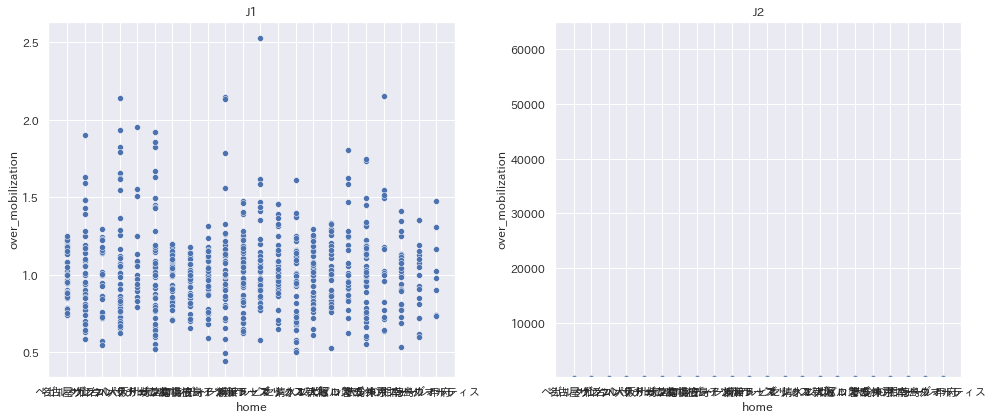

In [1692]:
# 複数の絵を同時に描きたい時にsubplots関数を使う
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].set_title("J1")
sns.scatterplot(x="home",y="over_mobilization",data=train[train["stage"]=="Ｊ１"], ax=ax[0])
ax[1].set_title("J2")
sns.scatterplot(x="home",y="over_mobilization",data=train[train["stage"]=="Ｊ１"], ax=ax[1])
plt.ylim(100,65000)
plt.tight_layout()

In [1693]:
train.head(1)

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,...,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km,mobilization,stage_stadium,stadium_mobilization,MONTH,WEEK,timezone,WEEK_timezone_num,nhk,WEATHER,temp_condition,hours,over_mobilization,holiday,referee_point,stadium_min,stadium_max
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,鎌田 次郎,上本 大海,田村 直也,富田 晋伍,角田 誠,...,ジュニーニョ,宮城県仙台市泉区七北田字柳78,19694,4,38.319158,140.881857,35.992776,140.641766,259.062331,0.926678,Ｊ１ユアテックスタジアム仙台,0.766782,3,土,1,土1,1,雨,-1.2,14,1.208529,0,1,11144,18863


In [1694]:
over4000=train[train["y"]>=40000]
over4000=over4000[['home','away']]
over4000['cnt'] = 1
over4000_pivot=over4000.groupby(['home','away']).sum()
over4000_pivot

cnt
home     away          
セレッソ大阪   ガンバ大阪        1
横浜Ｆ・マリノス アルビレックス新潟    1
         鹿島アントラーズ     1
浦和レッズ    アルビレックス新潟    1
         ガンバ大阪        1
         サガン鳥栖        1
         サンフレッチェ広島    2
         セレッソ大阪       2
         名古屋グランパス     2
         大宮アルディージャ    1
         川崎フロンターレ     1
         柏レイソル        1
         横浜Ｆ・マリノス     1
         鹿島アントラーズ     2
         ＦＣ東京         1
ＦＣ東京     セレッソ大阪       2

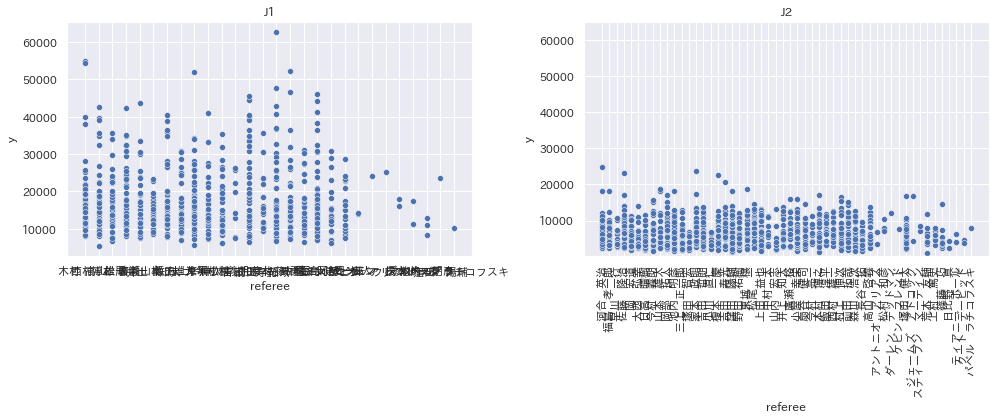

In [1695]:
# 複数の絵を同時に描きたい時にsubplots関数を使う
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].set_title("J1")
sns.scatterplot(x="referee",y="y",data=train[train["stage"]=="Ｊ１"], ax=ax[0])
plt.xticks(rotation=90)
ax[1].set_title("J2")
sns.scatterplot(x="referee",y="y",data=train[train["stage"]=="Ｊ２"], ax=ax[1])
plt.ylim(100,65000)
plt.tight_layout()

<AxesSubplot:>

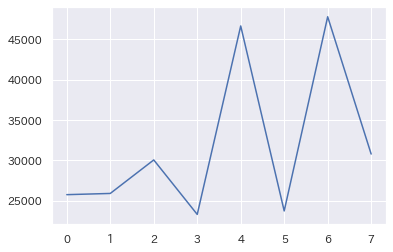

In [1696]:
dat = train[(train["home"]=="浦和レッズ")&(train["weather"]=="雨")].reset_index(drop=True) # indexがとびとびになるので、0,1,2になるようにリセット
dat["y"].plot()

In [1697]:
# train[(train["home"]=="浦和レッズ")&(train["weather"]=="雨")&(train["y"]>=45000)]
train[(train["home"]=="浦和レッズ")&(train["y"]>=45000)]

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,...,away_11,address,capa,tv_num,home_lat,home_long,away_lat,away_long,distance_km,mobilization,stage_stadium,stadium_mobilization,MONTH,WEEK,timezone,WEEK_timezone_num,nhk,WEATHER,temp_condition,hours,over_mobilization,holiday,referee_point,stadium_min,stadium_max
230,14224,46046,2012,Ｊ１,第２６節第１日,09/22(土・祝),16:04,浦和レッズ,ガンバ大阪,埼玉スタジアム２００２,スカパー／ｅ２／スカパー光,0,5,晴のち曇,24.3,69%,扇谷 健司,浦和レッズ,加藤 順大,坪井 慶介,永田 充,槙野 智章,平川 忠亮,鈴木 啓太,阿部 勇樹,...,家長 昭博,埼玉県さいたま市緑区中野田500,63700,3,35.902,139.714677,34.811971,135.541163,398.101422,0.722857,Ｊ１埼玉スタジアム２００２,0.58416,9,土,1,土1,0,晴,1.0,16,1.237430,1,1,23295,54905
298,14292,51879,2012,Ｊ１,第３４節第１日,12/01(土),15:34,浦和レッズ,名古屋グランパス,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／ＢＳ－ＴＢＳ／テレ玉,2,0,晴,5.6,71%,村上 伸次,浦和レッズ,加藤 順大,坪井 慶介,山田 暢久,槙野 智章,平川 忠亮,鈴木 啓太,阿部 勇樹,...,永井 謙佑,埼玉県さいたま市緑区中野田500,63700,4,35.902,139.714677,35.088621,137.171555,247.758039,0.814427,Ｊ１埼玉スタジアム２００２,0.58416,12,土,1,土1,0,晴,1.0,15,1.394185,0,1,23295,54905
784,14852,52293,2013,Ｊ１,第２節第１日,03/09(土),16:05,浦和レッズ,名古屋グランパス,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／テレ玉（録）,1,0,晴,21.6,24%,佐藤 隆治,浦和レッズ,加藤 順大,森脇 良太,永田 充,槙野 智章,梅崎 司,阿部 勇樹,鈴木 啓太,...,矢野 貴章,埼玉県さいたま市緑区中野田500,63700,3,35.902,139.714677,35.088621,137.171555,247.758039,0.820926,Ｊ１埼玉スタジアム２００２,0.58416,3,土,1,土1,0,晴,1.0,16,1.405310,0,1,23295,54905
866,14934,46649,2013,Ｊ１,第１１節第１日,05/11(土),19:03,浦和レッズ,鹿島アントラーズ,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉,3,1,雨,17.1,89%,佐藤 隆治,浦和レッズ,加藤 順大,森脇 良太,那須 大亮,槙野 智章,平川 忠亮,阿部 勇樹,鈴木 啓太,...,ダヴィ,埼玉県さいたま市緑区中野田500,63700,4,35.902,139.714677,35.992776,140.641766,84.249173,0.732323,Ｊ１埼玉スタジアム２００２,0.58416,5,土,0,土0,0,雨,1.0,19,1.253635,0,1,23295,54905
1016,15084,47790,2013,Ｊ１,第２８節第１日,10/05(土),16:05,浦和レッズ,大宮アルディージャ,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／テレ玉（録）,4,0,雨,19.9,91%,家本 政明,浦和レッズ,山岸 範宏,森脇 良太,那須 大亮,槙野 智章,平川 忠亮,阿部 勇樹,鈴木 啓太,...,ズラタン,埼玉県さいたま市緑区中野田500,63700,3,35.902,139.714677,35.918913,139.631820,7.710971,0.750235,Ｊ１埼玉スタジアム２００２,0.58416,10,土,1,土1,0,雨,1.0,16,1.284298,0,1,23295,54905
1048,15116,45607,2013,Ｊ１,第３２節第１日,11/23(土・祝),14:04,浦和レッズ,川崎フロンターレ,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／テレ玉,1,3,晴,14.3,33%,吉田 寿光,浦和レッズ,山岸 範宏,森脇 良太,那須 大亮,槙野 智章,平川 忠亮,阿部 勇樹,鈴木 啓太,...,大久保 嘉人,埼玉県さいたま市緑区中野田500,63700,3,35.902,139.714677,35.590090,139.647336,35.139697,0.715965,Ｊ１埼玉スタジアム２００２,0.58416,11,土,1,土1,0,晴,1.0,14,1.225632,1,1,23295,54905
1066,15134,54905,2013,Ｊ１,第３４節第１日,12/07(土),15:34,浦和レッズ,セレッソ大阪,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／テレ玉,2,5,晴,12.6,37%,木村 博之,浦和レッズ,山岸 範宏,森脇 良太,那須 大亮,槙野 智章,平川 忠亮,阿部 勇樹,鈴木 啓太,...,エジノ,埼玉県さいたま市緑区中野田500,63700,3,35.902,139.714677,34.615219,135.525871,406.993290,0.861931,Ｊ１埼玉スタジアム２００２,0.58416,12,土,1,土1,0,晴,1.0,15,1.475505,0,1,23295,54905
1654,15787,54350,2014,Ｊ１,第１４節第１日,05/17(土),14:04,浦和レッズ,セレッソ大阪,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／ＮＨＫ総合,1,0,晴,23.6,26%,木村 博之,浦和レッズ,西川 周作,森脇 良太,那須 大亮,槙野 智章,梅崎 司,青木 拓矢,阿部 勇樹,...,フォルラン,埼玉県さいたま市緑区中野田500,63700,3,35.902,139.714677,34.615219,135.525871,406.993290,0.853218,Ｊ１埼玉スタジアム２００２,0.58416,5,土,1,土1,1,晴,1.0,14,1.460590,0,1,23295,54905


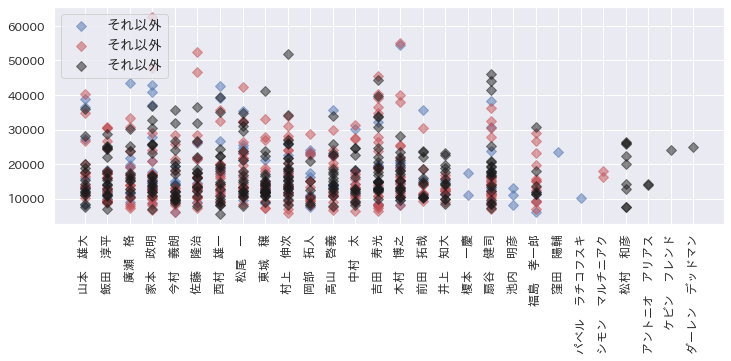

In [1698]:
plt.figure(figsize=(12,4))
plt.grid(True) # 目盛線の表示
plt.tick_params(labelsize = 12) # 目盛線のラベルサイズ

# グラフの描画 マークの設定(s:サイズ, c:色, marker:形, alpha:透過)
plt.scatter(x="referee",y="y",data=train[(train["stage"]=="Ｊ１")&(train["year"]==2014)], s=50, c="b", marker="D", alpha=0.5, label="それ以外")
plt.scatter(x="referee",y="y",data=train[(train["stage"]=="Ｊ１")&(train["year"]==2013)], s=50, c="r", marker="D", alpha=0.5, label="それ以外")
plt.scatter(x="referee",y="y",data=train[(train["stage"]=="Ｊ１")&(train["year"]==2012)], s=50, c="k", marker="D", alpha=0.5, label="それ以外")

plt.legend(loc="upper left", fontsize=14) # 凡例表示
plt.xticks(rotation=90)
plt.show()

In [1699]:
referee_df=train[(train['stage']=='Ｊ１')]
referee_df=referee_df[['referee','y']]
# referee_df['cnt'] = 1
referee_df=referee_df.groupby(['referee']).max()
referee_df=referee_df[referee_df['y']>=42000]
referee_df

,y
referee,
佐藤 隆治,52293
吉田 寿光,45607
家本 政明,62632
廣瀬 格,43564
扇谷 健司,46046
木村 博之,54905
村上 伸次,51879
松尾 一,42426
西村 雄一,42723
